# Spectrum changes with single lens imaging

At first, the pupil flane in frequency domain should be reveal.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io as sio
from skimage.transform import resize
import os
import numpy as np
import sys
import imp
sys.path.append("D:\\Workspace\\git_proj\\CCCode")
import imaging_process
imp.reload(imaging_process)
from imaging_process import ft2, ift2, Wavefront, tie_solution, img_val_norm, Check

PIXEL_SIZE = 5e-6
PIXEL_NUM = 512
WAVELENGTH = 500e-9

In [5]:
# import images
imgs_path = "D:\\Workspace\\datasets\\open_image_val_standard"
imgs_name_list = os.listdir(imgs_path)[0:2]
imgs_fpath_list = [os.path.join(imgs_path, img_name) for img_name in imgs_name_list]
amp_img = img_val_norm(resize(sio.imread(imgs_fpath_list[0]), (PIXEL_NUM, PIXEL_NUM)), 0.1, 1)
pha_img = img_val_norm(resize(sio.imread(imgs_fpath_list[1]), (PIXEL_NUM, PIXEL_NUM)), 0.2, 1.5)

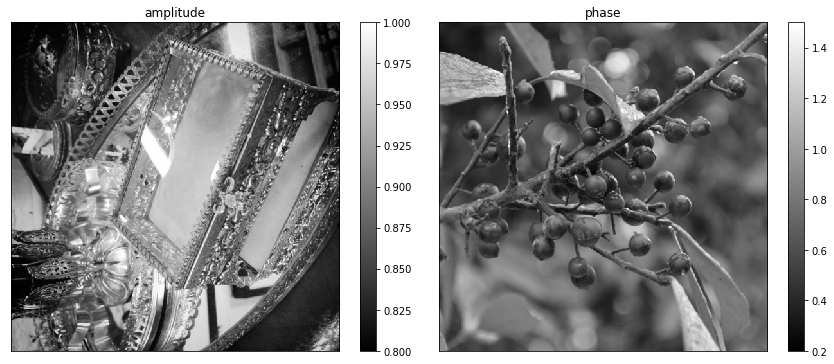

In [10]:
# plt.figure(figsize=[10, 4])
# plt.subplot(121)
# plt.imshow(amp_img, cmap="gray")
# plt.title("amplitude")
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(pha_img, cmap="gray")
# plt.title("phase")
# plt.colorbar()
# plt.tight_layout()
# plt.show()
Check.multi_img(amplitude=amp_img, phase=pha_img)

In [51]:
import imaging_process
imp.reload(imaging_process)
from imaging_process import ft2, ift2, Wavefront, tie_solution, img_val_norm, Check

ff = 100e-3
d1 = 2*ff
d2 = 2*ff

img_list = []
for r_na in np.arange(0.3, 1.0, 0.02):
    del wf_obj
    wf_obj = Wavefront.from_bioimage(amp_img, pha_img, WAVELENGTH, PIXEL_SIZE)
    print(r_na)
    imaging_pl_focus = wf_obj.lens_transfer(d1=d1, focus=ff, d2=d2, relative_na=r_na).wavefront
    img_intensity = abs(imaging_pl_focus*imaging_pl_focus.conj())
    img_list.append(img_intensity)

0.3
0.32
0.34
0.36000000000000004
0.38000000000000006
0.4000000000000001
0.4200000000000001
0.4400000000000001
0.46000000000000013
0.48000000000000015
0.5000000000000002
0.5200000000000002
0.5400000000000003
0.5600000000000003
0.5800000000000003
0.6000000000000003
0.6200000000000003
0.6400000000000003
0.6600000000000004
0.6800000000000004
0.7000000000000004
0.7200000000000004
0.7400000000000004
0.7600000000000005
0.7800000000000005
0.8000000000000005
0.8200000000000005
0.8400000000000005
0.8600000000000005
0.8800000000000006
0.9000000000000006
0.9200000000000006
0.9400000000000006
0.9600000000000006
0.9800000000000006


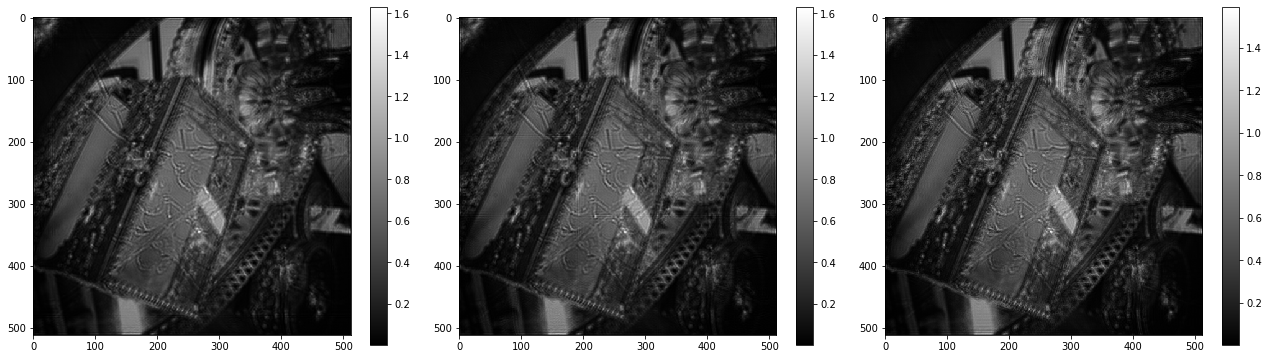

In [58]:
plt.figure(figsize=[18, 5])
plt.subplot(131)
plt.imshow(img_list[7], cmap="gray")
plt.colorbar()
plt.subplot(132)
plt.imshow(img_list[8], cmap="gray")
plt.colorbar()
plt.subplot(133)
plt.imshow(img_list[10], cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()

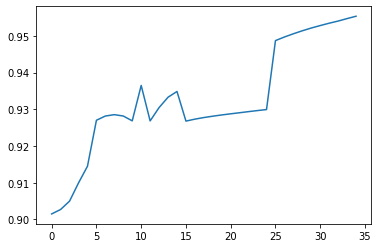

In [57]:
from cc_math import pearson_correlation_coefficient_comput, mse_compute

intensity = amp_img**2
corr = []
mse = []
for img in img_list:
    corr.append(pearson_correlation_coefficient_comput(img, np.rot90(intensity, 2)))
    mse.append(mse_compute(img, np.rot90(intensity, 2)))

plt.plot(corr)
# plt.plot(mse)
plt.show()

# Image Registration Using ECC (Enhanced Correlation Coefficient) Maximization

In [1]:
import cv2
import numpy as np
import os

image_path = "D:\\Workspace\\datasets\\TIE_experiment\\20200609\\2"
im1 = cv2.imread(os.path.join(image_path, "L_0.bmp"))
im2 = cv2.imread(os.path.join(image_path, "L_1.bmp"))
im3 = cv2.imread(os.path.join(image_path, "R_2.bmp"))
im4 = cv2.imread(os.path.join(image_path, "R_3.bmp"))

idx1 = 1024 - 512
idx2 = 1024 + 512

im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)[idx1:idx2, idx1:idx2]
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)[idx1:idx2, idx1:idx2]
im3_gray = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)[idx1:idx2, idx1:idx2]
im4_gray = cv2.cvtColor(im4, cv2.COLOR_BGR2GRAY)[idx1:idx2, idx1:idx2]

sz = im1_gray.shape

In [22]:
# Define the motion model
warp_mode = cv2.MOTION_TRANSLATION

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 1000;

# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-20;

# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

In [23]:
# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im3_gray,warp_matrix, warp_mode, criteria, None, 5)

In [24]:
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography 
    im3_aligned = cv2.warpPerspective (im3_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    # Use warpAffine for Translation, Euclidean and Affine
    im3_aligned = cv2.warpAffine(im3_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

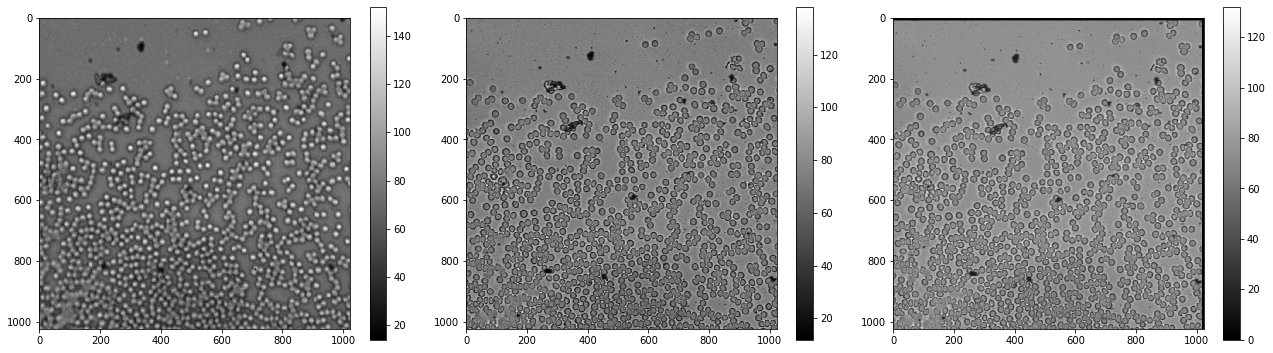

In [25]:
# Show final results
import matplotlib.pyplot as plt
%matplotlib inline

idx1 = 1024 - 512
idx2 = 1024 + 512

plt.figure(figsize=[18, 5])
plt.subplot(131)
plt.imshow(im1_gray, cmap="gray")
plt.colorbar()
plt.subplot(132)
plt.imshow(im3_gray, cmap="gray")
plt.colorbar()
plt.subplot(133)
plt.imshow(im3_aligned, cmap="gray")
plt.colorbar()
plt.tight_layout()
plt.show()